In [26]:
import pymongo
import matplotlib as mpl
mpl.use('pdf')
import matplotlib.pyplot as plt
from bson.son import SON
import pandas as pd

%matplotlib inline  

C:\Users\nicok\Miniconda3\envs\asl\lib\site-packages\ipykernel_launcher.py:3: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
ip = "localhost"
port = "27017"

info = {
    'experiment_suite_id' : 'process_demo2'
}

client = pymongo.MongoClient(f"mongodb://{ip}:{port}/")

db = client[info['experiment_suite_id']]
results = db.collection['results']



27851965176.537918


In [30]:
for c in results.find({}):
    print(c['mw_stats'][0]['op'][4])
    #print(len(c['mw_stats'][1]['hist'][10]['rt_hist']))

{'time': datetime.datetime(1900, 1, 1, 20, 30, 39, 511000), 'tid': '[23]', 'stat_type': 'op', 'slot': 4, 'op_type': 'get', 'qwt_count': 2180, 'qwt_mean': 4278.292660550459, 'qwt_m2': 25311432555.282597, 'rt_count': 1094, 'rt_mean': 5799.312614259596, 'rt_m2': 15778987925.085928, 'ntt_count': 1094, 'ntt_mean': 8.939670932358327, 'ntt_m2': 77206.01828153552, 'wtt_count': 1094, 'wtt_mean': 1505.9908592321765, 'wtt_m2': 1328092651.9085925, 'sst0_count': 460.606946983547, 'sst0_mean': 1094, 'sst0_m2': 885952046.9872028, 'sst1_count': 492.19195612431463, 'sst1_mean': 1094, 'sst1_m2': 930670627.6892138, 'sst2_count': 484.5466179159038, 'sst2_mean': 1094, 'sst2_m2': 1008975777.1224865}


In [ ]:
doc = {
   "exp":"exp31",
   "mw_stats":[
      {
          "id": "mw00",
          "ops":[
             {"type": "set", "value": 5},
             {"type": "get", "value": 7}    
          ]
      },
        {
          "id": "mw00",
          "ops":[
             {"type": "set", "value": 5},
             {"type": "get", "value": 7}    
          ]
      }
   ]
}

demo_db = client['test']
demo_r = demo_db.collection['xy']

demo_r.insert(doc)

In [ ]:

pipeline=[{"$unwind":"$mw_stats"}]
for x in demo_r.aggregate(pipeline):
    print(x)

In [ ]:
from datetime import datetime

datetime_object = datetime.strptime('19:28:13.451'.split(".")[0], '%H:%M:%S')

print(datetime_object)

In [ ]:
d = {'count': 8, 
'rt_arr2': [
{'m2': '667.0406249999994', 'mean': '1.2281250000000015', 'count': '960'}, 
{'m2': '1236.5497326203222', 'mean': '1.300534759358289', 'count': '935'}, 
{'m2': '898.9821428571427', 'mean': '1.3080357142857142', 'count': '896'}, 
{'m2': '631.1030368763547', 'mean': '1.2548806941431647', 'count': '922'}, 
{'m2': '583.0053821313236', 'mean': '1.2744886975242187', 'count': '929'}, 
{'m2': '837.7720979765719', 'mean': '1.228966986155485', 'count': '939'}, 
{'m2': '675.9903846153846', 'mean': '1.2467948717948716', 'count': '936'}, 
{'m2': '634.7920585161966', 'mean': '1.2173458725182873', 'count': '957'}
], 
'throughput': 1494.8, 
'slot': '17:10:23', 
'workload_ratio': '0:1', 
'ops_type': 'get', 
'n_worker_per_mw': 8, 
'n_vc': 1, 
'rep': 0, 

'rt_m2': {'mean': 1.2568905539202568, 'count': 7474, 'm2': 7475.716301065702}
    
}

count_a = 0
m2_a = 0.0
mean_a = 0.0
for b in d['rt_arr2']:
    count_b = int(b['count'])
    m2_b = float(b['m2'])
    mean_b = float(b['mean'])
    
    delta = mean_b - mean_a
    
    mean_a = mean_a + delta * count_b / (count_a + count_b)
    
    m2_a = m2_a + m2_b + delta**2 * count_a * count_b / (count_a + count_b)
    count_a += count_b
   
    
print(f"Count={count_a}, M2={m2_a}, Mean={mean_a}")

In [ ]:
df.to_csv("./test.csv")

In [10]:
from datetime import datetime
from datetime import timedelta
import numpy as np

exp = "exp31"



pipeline = [
        {"$match": {"exp": exp}},
        {"$addFields":{"num_clients": {"$multiply": ["$exp_config.n_client", 
                                                     "$exp_config.n_instances_mt_per_machine",
                                                     "$exp_config.n_threads_per_mt_instance",
                                                     "$exp_config.n_vc"
                                                    ]}
                      }
        },
        {"$unwind":"$mw_stats"},
        {"$unwind":"$mw_stats.ops"},
        {"$group": {"_id" : {"slot": "$mw_stats.ops.slot", 
                             "workload_ratio": "$exp_config.workload_ratio",
                             "ops_type": "$mw_stats.ops.type",
                             "n_worker_per_mw": "$exp_config.n_worker_per_mw",
                             "n_vc": "$exp_config.n_vc",
                             "num_clients": "$num_clients",
                             "rep":"$repetition"}, 
                   "count" : {"$sum" :  1},
                   "sum_rt_count" : {"$sum": "$mw_stats.ops.rt_count"},
                   "rt_arr" :  {"$push": {"m2":"$mw_stats.ops.rt_m2", "mean":"$mw_stats.ops.rt_mean", "count":"$mw_stats.ops.rt_count"}},
                   "qwt_arr" : {"$push": {"m2":"$mw_stats.ops.qwt_m2", "mean":"$mw_stats.ops.qwt_mean", "count":"$mw_stats.ops.qwt_count"}},
                   "ntt_arr" : {"$push": {"m2":"$mw_stats.ops.ntt_M2", "mean":"$mw_stats.ops.ntt_mean", "count":"$mw_stats.ops.ntt_count"}},
                   "wtt_arr" : {"$push": {"m2":"$mw_stats.ops.wtt_M2", "mean":"$mw_stats.ops.wtt_mean", "count":"$mw_stats.ops.wtt_count"}},
                   }
        },
        {"$addFields":{ "rt": {"$reduce": reduce_stat("rt_arr")},
                        "qwt": {"$reduce": reduce_stat("qwt_arr")},
                        "ntt": {"$reduce": reduce_stat("ntt_arr")},
                        "wtt": {"$reduce": reduce_stat("wtt_arr")}
                     }
        },
        {"$addFields": {"throughput": {"$divide" : ["$sum_rt_count", 5.0]},
                        "rt_mean" : "$rt.mean",
                        "rt_std":{"$sqrt": {"$divide": ["$rt.m2", {"$subtract":["$rt.count", 1]}]}},
                        "qwt_mean" : "$qwt.mean",
                        "qwt_std":{"$sqrt": {"$divide": ["$qwt.m2", {"$subtract":["$qwt.count", 1]}]}},
                        "ntt_mean" : "$ntt.mean",
                        "ntt_std":{"$sqrt": {"$divide": ["$ntt.m2", {"$subtract":["$ntt.count", 1]}]}},
                        "wtt_mean" : "$wtt.mean",
                        "wtt_std":{"$sqrt": {"$divide": ["$wtt.m2", {"$subtract":["$wtt.count", 1]}]}},    
                       }},
        {"$project": {"_id": 0,
                        "slot": "$_id.slot",
                        "workload_ratio": "$_id.workload_ratio",
                        "ops_type": "$_id.ops_type",
                        "n_worker_per_mw": "$_id.n_worker_per_mw",
                        "num_clients":"$_id.num_clients",
                        "rep": "$_id.rep",
                        "count": 1,
                        "throughput_mean":"$throughput",
                        "rt_mean" : "$rt_mean",
                        "rt_std": "$rt_std",
                        "qwt_mean" : "$qwt_mean",
                        "qwt_std": "$qwt_std",
                        "ntt_mean" : "$ntt_mean",
                        "ntt_std": "$ntt_std",
                        "wtt_mean" : "$wtt_mean",
                        "wtt_std": "$wtt_std"
                     }
        },
        {"$match":{ "throughput_mean": { "$gt": 0 }}},
        {"$sort":SON([("workload_ratio",1),("n_worker_per_mw",1),("num_clients", 1), ("rep",1), ("slot", 1)])},
]

# create dataframe
cursor = results.aggregate(pipeline, allowDiskUse=True)
df =  pd.DataFrame(list(cursor))

config_cols = ["workload_ratio", "ops_type", "n_worker_per_mw", "num_clients", "rep", "slot"]
value_cols = ["throughput_mean", "rt_mean", "rt_std", "qwt_mean", "qwt_std", "ntt_mean", "ntt_std", "wtt_mean", "wtt_std"]
df = df.set_index(config_cols, drop=False)

df_slot, config_cols_slot, value_cols_slot = aggregate_slots(df, config_cols=config_cols, value_cols=value_cols)

df_rep, config_cols_rep, value_cols_rep = aggregate_repetitions(df_slot, config_cols=config_cols_slot, value_cols=value_cols_slot)

print("DF AGGREGATED OVER THREADS")
display(df)


print("DF AGGREGATED OVER SLOTS")
display(df_slot)


print("DF AGGREGATED OVER REPETITIONS")
display(df_rep)



DF AGGREGATED OVER THREADS


count  \
workload_ratio ops_type n_worker_per_mw num_clients rep slot          
0:1            get      8               6           0   0         8   
                                                        1         8   
                                                        2         8   
                                                        3         8   
                                                        4         8   
                                                        5         8   
                                                        6         8   
                                                        7         8   
                                                        8         8   
                                                        9         8   
                                                        10        8   
                                                        11        8   
                                                        12        8   
                                                        13        8   
                                                        14        8   
                                                        15        8   
                                                    1   0         8   
                                                        1         8   
                                                        2         8   
                                                        3         8   
                                                        4         8   
                                                        5         8   
                                                        6         8   
                                                        7         8   
                                                        8         8   
                                                        9         8   
                                                        10        8   
                                                        11        8   
                                                        12        8   
                                                        13        8   
...                                                             ...   
1:0            set      64              192         1   2        64   
                                                        3        64   
                                                        4        64   
                                                        5        64   
                                                        6        64   
                                                        7        64   
                                                        8        64   
                                                        9        64   
                                                        10       64   
                                                        11       64   
                                                        12       64   
                                                        13       64   
                                                        14       64   
                                                        15       64   
                                                    2   0        64   
                                                        1        64   
                                                        2        64   
                                                        3        64   
                                                        4        64   
                                                        5        64   
                                                        6        64   
                                                        7        64   
                                                        8        64   
                                                        9        64   
               

DF AGGREGATED OVER SLOTS


throughput_slot_mean  \
workload_ratio ops_type n_worker_per_mw num_clients rep                         
0:1            get      8               6           0             2923.400000   
                                                    1             2875.461538   
                                                    2             2912.000000   
                                        24          0             2946.569231   
                                                    1             2944.538462   
                                                    2             2938.076923   
                                        72          0             2938.723077   
                                                    1             2942.107692   
                                                    2             2944.569231   
                                        96          0             2944.461538   
                                                    1             2946.169231   
                                                    2             2946.569231   
                                        144         0             2942.676923   
                                                    1             2942.076923   
                                                    2             2943.107692   
                                        192         1             2941.830769   
                                                    2             2937.246154   
                        16              6           0             2899.276923   
                                                    1             2886.507692   
                                                    2             2889.969231   
                                        24          0             2950.000000   
                                                    1             2950.830769   
                                                    2             2946.307692   
                                        72          0             2944.476923   
                                                    1             2941.615385   
                                                    2             2941.661538   
                                        96          0             2950.984615   
                                                    1             2949.369231   
                                                    2             2953.646154   
                                        144         0             2954.323077   
...                                                                       ...   
1:0            set      32              72          0            10903.846154   
                                                    1            10942.200000   
                                                    2            10771.615385   
                                        96          0            10981.769231   
                                                    1            10869.430769   
                                                    2            10853.984615   
                                        144         0            10962.338462   
                                                    1            10891.030769   
                                                    2            10979.446154   
                                        192         0            10979.476923   
                                                    1            10893.538462   
                                                    2            10900.230769   
                        64              6           0             3133.876923   
                                                    1             2922.292308   
                                                    2             3021.092308   
                                        24          0             7925.107692   
                                                    1             7962.646154   
       

DF AGGREGATED OVER REPETITIONS


throughput_rep_mean  \
workload_ratio ops_type n_worker_per_mw num_clients                        
0:1            get      8               6                    2903.620513   
                                        24                   2943.061538   
                                        72                   2941.800000   
                                        96                   2945.733333   
                                        144                  2942.620513   
                                        192                  2939.538462   
                        16              6                    2891.917949   
                                        24                   2949.046154   
                                        72                   2942.584615   
                                        96                   2951.333333   
                                        144                  2954.753846   
                                        192                  2954.358974   
                        32              6                    2894.087179   
                                        24                   2956.887179   
                                        72                   2945.800000   
                                        96                   2949.974359   
                                        144                  2950.610256   
                                        192                  2947.594872   
                        64              6                    2896.276923   
                                        24                   2953.671795   
                                        72                   2968.984615   
                                        96                   2959.958974   
                                        144                  2951.241026   
                                        192                  2949.353846   
1:0            set      8               6                    3174.287179   
                                        24                   7158.138462   
                                        72                   7140.374359   
                                        96                   7030.456410   
                                        144                  7051.805128   
                                        192                  7079.646154   
                        16              6                    3071.451282   
                                        24                   7828.256410   
                                        72                   8609.533333   
                                        96                   8566.374359   
                                        144                  8724.082051   
                                        192                  8659.292308   
                        32              6                    2988.241026   
                                        24                   7946.076923   
                                        72                  10872.553846   
                                        96                  10901.728205   
                                        144                 10944.271795   
                                        192                 10924.415385   
                        64              6                    3025.753846   
                                        24                   7927.994872   
                                        72                  11538.246154   
                                        96                  12566.794872   
                                        144                 12833.866667   
                                        192                 12932.594872   

                                                     throughput_rep_std  \
workload_ratio ops_type n_worker_per_mw num_clients                       
0:1            get      8               6                     25.043679   
                           

In [33]:
x = df_rep.loc['1:0', 'set', 16]
display(x)

x.reset_index(level=0, inplace=True)
display(x)

display(x.loc[:,'throughput_rep_mean'])

display(x.loc[:,'throughput_rep_mean'].values)
display(x.loc[:,'num_clients'].values)


,throughput_rep_mean,throughput_rep_std,rt_rep_mean,rt_rep_std,qwt_rep_mean,qwt_rep_std,ntt_rep_mean,ntt_rep_std,wtt_rep_mean,wtt_rep_std
num_clients,,,,,,,,,,
6,3071.451282,117.212372,1.133371,0.060645,0.132105,0.023180,0.016697,0.000540,0.984569,0.038650
24,7828.256410,53.632381,2.135653,0.014850,0.498513,0.011268,0.015961,0.000874,1.621180,0.008501
72,8609.533333,164.509369,7.291841,0.077584,5.425565,0.044218,0.014724,0.000341,1.851553,0.033395
96,8566.374359,31.585070,10.084976,0.030445,8.205254,0.035131,0.014667,0.000231,1.865056,0.006277
144,8724.082051,31.381464,15.387328,0.066577,13.540498,0.061214,0.014571,0.000445,1.832258,0.006555
192,8659.292308,136.829189,21.138753,0.296093,19.277880,0.266824,0.014289,0.000215,1.846584,0.029199


,num_clients,throughput_rep_mean,throughput_rep_std,rt_rep_mean,rt_rep_std,qwt_rep_mean,qwt_rep_std,ntt_rep_mean,ntt_rep_std,wtt_rep_mean,wtt_rep_std
0,6,3071.451282,117.212372,1.133371,0.060645,0.132105,0.023180,0.016697,0.000540,0.984569,0.038650
1,24,7828.256410,53.632381,2.135653,0.014850,0.498513,0.011268,0.015961,0.000874,1.621180,0.008501
2,72,8609.533333,164.509369,7.291841,0.077584,5.425565,0.044218,0.014724,0.000341,1.851553,0.033395
3,96,8566.374359,31.585070,10.084976,0.030445,8.205254,0.035131,0.014667,0.000231,1.865056,0.006277
4,144,8724.082051,31.381464,15.387328,0.066577,13.540498,0.061214,0.014571,0.000445,1.832258,0.006555
5,192,8659.292308,136.829189,21.138753,0.296093,19.277880,0.266824,0.014289,0.000215,1.846584,0.029199


0    3071.451282
1    7828.256410
2    8609.533333
3    8566.374359
4    8724.082051
5    8659.292308
Name: throughput_rep_mean, dtype: float64

array([3071.45128205, 7828.25641026, 8609.53333333, 8566.37435897,
       8724.08205128, 8659.29230769])

array([  6,  24,  72,  96, 144, 192], dtype=int64)

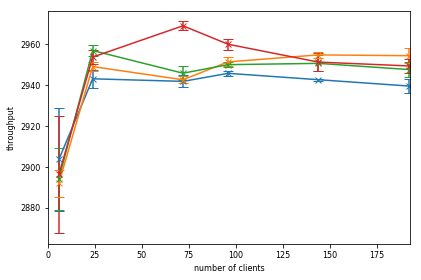

In [44]:
workload_ratio = "1:0"
ops_type = "set"

workload_ratio = "0:1"
ops_type = "get"


plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

# width as measured in inkscape
width = 3.487
height = width / 1.618

fig, ax = plt.subplots()
fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)



for n_worker_per_mw in [8, 16, 32, 64]:
#n_worker_per_mw = 16

    x = df_rep.loc[workload_ratio, ops_type, n_worker_per_mw]
    x.reset_index(level=0, inplace=True)
    throughput_means = x.loc[:,'throughput_rep_mean'].values
    throughput_stds = x.loc[:,'throughput_rep_std'].values
    rt_means = x.loc[:,'rt_rep_mean'].values
    rt_stds = x.loc[:,'rt_rep_std'].values
    
    clients = x.loc[:,'num_clients'].values

    plt.errorbar(clients, throughput_means, throughput_stds, capsize=5, marker='x')



ax.set_ylabel('throughput')
ax.set_xlabel('number of clients')
ax.set_xlim(0, clients[-1]+1)

plt.show()

#fig.set_size_inches(width, height)
#fig.savefig('./plot.pdf')

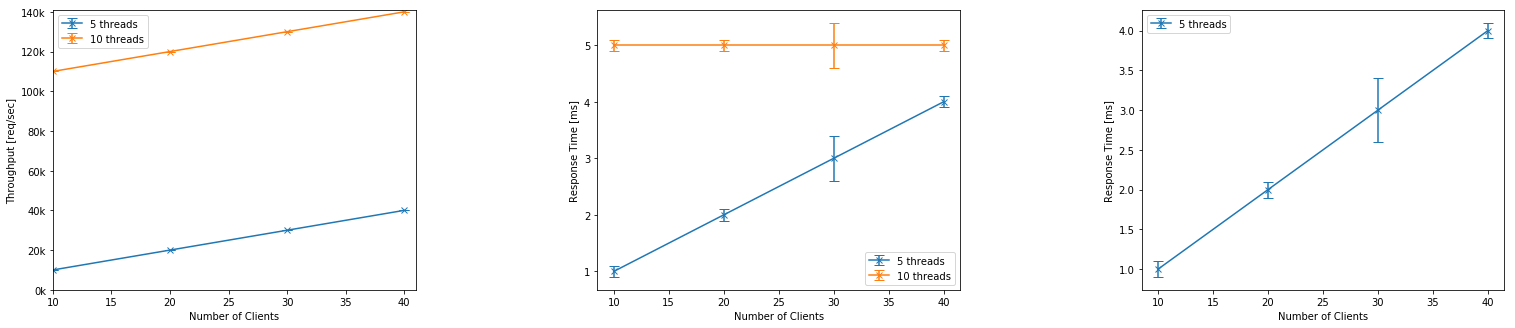

In [107]:
import matplotlib.ticker as ticker



def throughput_nc_plot(ax, throughput_dict, client_arr):
    
    if ax.get_xlim() == (0, 1.0):
        ax.set_xlim(client_arr[0], client_arr[-1]+1)
        
    set_y_lim =  ax.get_ylim() == (0, 1.0)
    max_y = 0
   
    for label, throughput in throughput_dict.items():
        ax.errorbar(client_arr, throughput['y'], throughput['err'], capsize=5, marker='x', label=label)
        m = max(throughput['y'])
        if m > max_y:
            max_y = m
    
    if set_y_lim:
        ax.set_ylim(0, max_y+1000)
    
    ax.legend()
    ax.set_ylabel('Throughput [req/sec]')
    ax.set_xlabel('Number of Clients')
    
    formatter = ticker.FuncFormatter(lambda x, pos : f"{int(x/1000)}k")
    ax.yaxis.set_major_formatter(formatter)
    
def rt_nc_plot(ax, responsetime_dict, client_arr):
   
    for label, responsetime in responsetime_dict.items():
        ax.errorbar(client_arr, responsetime['y'], responsetime['err'], capsize=5, marker='x',label=label)
    
    ax.legend()
    ax.set_ylabel('Response Time [ms]')
    ax.set_xlabel('Number of Clients')
    
def qwt_nc_plot(ax):
    
    
def nt_nc_plot(ax):
    
    
def wtt_nc_plot(ax):
    

def init():
    fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97, wspace = 0.5, hspace = 0.2)
    
    plt.rc('font', family='serif', serif='Times')
    plt.rc('text', usetex=False)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes', labelsize=10)


fig = plt.figure()

init()
ax = fig.add_subplot(1,3,1)

throughput_dict = {
    "5 threads" : {"y":[10000,20000,30000,40000], "err":[0.1, 0.1, 0.4, 0.1]},
    "10 threads" : {"y":[110000,120000,130000,140000], "err": [0.1, 0.1, 0.4, 0.1]}
}
client_arr = [10, 20, 30, 40]
              

throughput_numclients_plot(ax, throughput_dict, client_arr)

ax = fig.add_subplot(1,3,2)
throughput_dict = {
    "5 threads" : {"y":[1,2,3,4], "err":[0.1, 0.1, 0.4, 0.1]},
    "10 threads" : {"y":[5,5,5,5], "err": [0.1, 0.1, 0.4, 0.1]}
}
responsetime_numclients_plot(ax, throughput_dict, client_arr)

ax = fig.add_subplot(1,3,3)
throughput_dict = {
    "5 threads" : {"y":[1,2,3,4], "err":[0.1, 0.1, 0.4, 0.1]}
}
responsetime_numclients_plot(ax, throughput_dict, client_arr)

width = 24
height = width / 5
fig.set_size_inches(width, height)             
plt.show()


In [4]:
def aggregate_slots(df, config_cols, value_cols, start_slot=1, end_slot=13):
    # filter slots (warmup and cooldown phase)
    df = df.loc[(df.slot>=start_slot) & (df.slot<=end_slot)]
    
    # want to group over slots -> remove slots from config columns
    config_cols.remove('slot')
    # create a dict to aggregate all value columns ending with mean and calc the mean and sample std
    # e.g.{'throughput_mean': ['mean', 'std'], 'rt_mean:['mean', 'std'], ...}
    agg_dict = {col: ['mean', 'std'] for col in value_cols if col.endswith('mean')}
    
    # group over different selected slots
    df = df.groupby(level=config_cols).agg(agg_dict)
    
    # column renaming and level flattening
    value_cols = [x[0].split("_")[0] + "_slot_" + x[1] for x in df.columns.ravel()]
    df.columns = value_cols
    
    return df, config_cols, value_cols


def aggregate_repetitions(df, config_cols, value_cols):
    
    # want to group over repetitions -> remove rep from config columns
    config_cols.remove('rep')
    # create a dict to aggregate all value columns ending with mean and calc the mean and sample std
    # e.g.{'throughput_slot_mean': ['mean', 'std'], 'rt_slot_mean:['mean', 'std'], ...}
    agg_dict = {col: ['mean', 'std'] for col in value_cols if col.endswith('mean')}
    
    # group over repetitions
    df = df.groupby(level=config_cols).agg(agg_dict)

    # column renaming and level flattening
    value_cols = [x[0].split("_")[0] + "_rep_" + x[1] for x in df.columns.ravel()]
    df.columns = value_cols
    
    return df, config_cols, value_cols

In [5]:
def reduce_stat(arr):
    d = {"input": {"$filter": {"input": f"${arr}",
                                                                    "as":"x",
                                                                    "cond":{"$gt":["$$x.count", 0.0]}
                                                                   }
                                                       },
                                            "initialValue": {"mean": 0.0,
                                                             "count": 0,
                                                             "m2":0.0},
                                            "in": {"mean":{"$sum":["$$value.mean", 
                                                                    {"$multiply":[{"$subtract": [{"$toDouble":"$$this.mean"}, "$$value.mean"]}, 
                                                                                  {"$divide":["$$this.count", 
                                                                                              {"$sum":["$$this.count","$$value.count"]}]}
                                                                                 ]
                                                                    }
                                                                  ]},
                                                   "m2" : {"$sum" : ["$$value.m2", 
                                                                        "$$this.m2",
                                                                        {"$multiply": [
                                                                                        {"$pow":[
                                                                                            {"$subtract": [
                                                                                                "$$this.mean", 
                                                                                                "$$value.mean"]
                                                                                            }, 2]
                                                                                        },
                                                                                       {"$divide": [
                                                                                           {"$multiply": [
                                                                                               "$$value.count", 
                                                                                               "$$this.count"
                                                                                           ]},
                                                                                            {"$sum": [
                                                                                                "$$value.count", 
                                                                                                "$$this.count"
                                                                                            ]}
                                                                                       ]}
                                                                        ]}
                                                                  ]},
                                                   "count": {"$sum":["$$value.count", "$$this.count"]},
                                                  }
                                             }
    return d
    

In [ ]:
def get_plot_data(workload, n_worker_per_mw=0):
    
    t = {
        "write-only": "1:0",
        "read-only": "0:1"
    }
    
    assert(workload in t)
    
    pipeline = [
        {"$match": {"exp_config.workload_ratio" : t[workload], "exp_config.n_worker_per_mw" : n_worker_per_mw}},
        {"$unwind" : "$client_stats"},
        {"$group" : {"_id" : {"_id" : "$_id",
                              "n_clients" : {"$multiply": ["$exp_config.n_client", 
                                                                                "$exp_config.n_instances_mt_per_machine", 
                                                                                "$exp_config.n_threads_per_mt_instance", 
                                                                                "$exp_config.n_vc"]}},
                     "client_throughput_sum" :{"$sum" :  "$client_stats.totals.Ops/sec"},
                     "client_response_time_sum" :{"$sum" :  "$client_stats.totals.Latency"}}}, 
        {"$group" : {"_id" : {"n_clients" : "$_id.n_clients"}, 
                     "client_throughput_avg" :{"$avg" :  "$client_throughput_sum"},
                     "client_throughput_std" :{"$stdDevSamp" :   "$client_throughput_sum"},
                     "client_response_time_avg" :{"$avg" :  "$client_response_time_sum"},
                     "client_response_time_std" :{"$stdDevSamp" :  "$client_response_time_sum"}}},
        {"$sort":SON([("_id.n_clients", 1)])}
    ]
    
    result = {
        'n_clients' : [], 
        'client_throughput_avg': [], 
        'client_throughput_std': [], 
        'client_response_time_avg': [],
        'client_response_time_std': [],
        'mw_throughput_avg': [], 
        'mw_throughput_std': [],
        'mw_response_time_avg': [],
        'mw_response_time_std': []
    }
    
    for d in results.aggregate(pipeline):
        result['n_clients'].append(d['_id']['n_clients'])
        result['client_throughput_avg'].append(d['client_throughput_avg'])
        result['client_throughput_std'].append(d['client_throughput_std'])
        result['client_response_time_avg'].append(d['client_response_time_avg'])
        result['client_response_time_std'].append(d['client_response_time_std'])
        #result['mw_throughput_avg'].append(d['mw_throughput_avg'])
        #result['mw_throughput_std'].append(d['mw_throughput_std'])
        #result['mw_response_time_avg'].append(d['mw_response_time_avg'])
        #result['mw_response_time_std'].append(d['mw_response_time_std'])
    
    return result

In [ ]:
def build_plot(n_clients, avg, std, ylabel):
   
    plt.rc('font', family='serif', serif='Times')
    plt.rc('text', usetex=False)
    plt.rc('xtick', labelsize=8)
    plt.rc('ytick', labelsize=8)
    plt.rc('axes', labelsize=8)

    # width as measured in inkscape
    width = 3.487
    height = width / 1.618

    fig, ax = plt.subplots()
    fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)

    plt.errorbar(n_clients, avg, std, capsize=3)

    ax.set_ylabel(ylabel)
    ax.set_xlabel('number of clients')
    ax.set_xlim(0, n_clients[-1]+1)

    fig.set_size_inches(width, height)
    fig.savefig('./plot.pdf')
    

data = get_plot_data("write-only")
print(data)
build_plot(n_clients=data['n_clients'], avg=data['client_throughput_avg'] , std=data['client_throughput_std'], ylabel='throughput (ops/sec)')

print(data['client_response_time_avg'])
build_plot(n_clients=data['n_clients'], avg=data['client_response_time_avg'] , std=data['client_response_time_std'], ylabel='response time')
